# Contextual Bandits Agent with Policy Gradient Method (Stochastic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.  

In [35]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd


In [36]:
import traceback
from scipy.special import expit
from tqdm.notebook import tnrange

In [37]:
class PredictionMarket:
    n_outcomes = 0
    outcomes_list = []
    
    def __init__(self, outcomes_list):
        self.outcomes_list = outcomes_list.copy()
        self.n_outcomes = len(outcomes_list)
        self.init_prediction = np.ones(self.n_outcomes)/ self.n_outcomes
        self.current_prediction = self.init_prediction
        
    def report(self, prediction):
        assert len(prediction) == self.n_outcomes, 'Number of outcomes not fit!'
        assert sum(prediction) == 1, print('Probabilities not sum to one!', prediction)
        # Record the contract if multiple traders.
        self.current_prediction = prediction.copy()
        
    def log_resolve(self, materialised_index):
        assert materialised_index < self.n_outcomes, 'Index out of scope!'
        scores = np.log(self.current_prediction) - np.log(self.init_prediction)
        return scores[materialised_index]

In [38]:
class Bucket:
    
    def __init__(self, prior_red = 0.5):
        assert prior_red >= 0, 'Prior can not be negative!'
        assert prior_red <=1, 'Prior can not greater than one!'
        
        self.prior_red = prior_red
        self.colour = np.random.choice(['red_bucket', 'blue_bucket'], p=(self.prior_red, 1 - self.prior_red))
        if self.colour == 'red_bucket':
            self.ball_list = ['red', 'red', 'blue']
        else:
            self.ball_list = ['blue', 'blue', 'red']
    
    def signal(self):
        return np.random.choice(self.ball_list)

In [39]:
class Agent:
    
    def __init__(self, feature_shape, learn_rate, beta, experience_size = 512, batch_size = 16,beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8):
        # Actor weights
        self.theta_mean = np.zeros(feature_shape)
        self.theta_std = np.zeros(feature_shape)
        # Critic weights
        self.w_v = np.zeros(feature_shape)
        self.beta = beta
        self.learn_rate = learn_rate
        self.baseline = 0
        
        # Momentum variables
        self.beta1 = beta1
        self.v_dw_mean = np.zeros(feature_shape)
        self.v_dw_std = np.zeros(feature_shape)
        
        # RMSprop variables
        self.beta2 = beta2
        self.epsilon = epsilon
        self.s_dw_mean = np.zeros(feature_shape)
        self.s_dw_std = np.zeros(feature_shape)

        # Experience replay
        self.experience = np.zeros((experience_size, feature_shape[1] + 6))
        self.batch_size = batch_size
        self.experience_size = experience_size
        
        
    def sigmoid(self, preference):
        return 1/ (1 + np.exp(-preference))
    
    def gaussian(self, x, mu, sigma):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))
    
    def gradient_approx(self, features, epsilon = 1e-7):
        
        J_plus = np.zeros(self.theta_mean.shape)
        J_minus = np.zeros(self.theta_mean.shape)
        
        for i in range(J_plus.shape[1]):
            self.theta_mean[:, i] += epsilon
            reports = self.report(features)
            J_plus[:, i] = (np.log(reports[0]) - np.log(0.5) )
            self.theta_mean[:, i] -= epsilon
            
        for i in range(J_minus.shape[1]):
            self.theta_mean[:, i] -= epsilon
            reports = self.report(features)
            J_minus[:, i] = (np.log(reports[0]) - np.log(0.5) )
            self.theta_mean[:, i] += epsilon
    
        gradapprox = (J_plus - J_minus)/ (2*epsilon)

        return gradapprox
    
    def report(self, features_list):
        
        self.features = np.array([features_list])

        [[self.mean]] = np.dot(self.theta_mean, self.features.T)
        [[self.std]] = np.exp(np.dot(self.theta_std, self.features.T))
        
            
        self.h = np.random.normal(self.mean, self.std)
        
        self.pi = self.sigmoid(self.h)
        
        if np.isnan(self.pi):
            print('h: ', self.h)
            print('mean:', self.mean)
            print('std:', self.std)
            raise AssertionError('Warning: report is None !!!')
        
        return [self.pi, 1 - self.pi]
    
    def __generate_log_policy_grad(self):
#         gradient_mean = np.array([self.features]) *\
#         ((self.h - self.mean)/ self.std**2) \
#         * self.gaussian(self.h, self.mean, self.std) \
#         * (1 - self.pi)
        
        gradient_mean = np.array([self.features]) *\
        ((self.h - self.mean)/ self.std**2) \
#         * self.pi * (1 - self.pi)

               
        
#         gradient_std = np.array([self.features]) *\
#         ((self.h - self.mean)**2 / self.std**2 - 1) \
#         * self.gaussian(self.h, self.mean, self.std) \
#         * (1 - self.pi)

        gradient_std = np.array([self.features]) *\
        ((self.h - self.mean)**2 / self.std**2 - 1) \
#         * self.pi *(1 - self.pi)  
        

        
        return [gradient_mean, gradient_std]
    
    def __print_algorithm(self, t, algorithm):
        if t == 0:
            print('Updating weights with ' + algorithm + ' algorithm.')

    def store_experience(self, reward, t):
        
        [[v]] = np.dot(self.w_v, self.features.T)
        delta = reward - v
        
        idx = t%self.experience_size
        self.experience[idx, :3] = self.features
        self.experience[idx, 3] = self.h
        self.experience[idx, 4] = self.mean
        self.experience[idx, 5] = self.std
        self.experience[idx, 6] = self.pi
        self.experience[idx, 7] = reward
        # self.experience[idx, 7] = delta
        self.experience[idx, 8] = delta
    

        return v

    def __sample_experience(self, t):

        if t < self.batch_size:
            return self.experience[:t+1, :]
        elif self.batch_size <= t < self.experience_size:
            idx = np.random.randint(low=0, high=t+1, size=self.batch_size)
            return self.experience[idx, :]
        else:
            idx = np.random.randint(self.experience_size, size=self.batch_size)
            return self.experience[idx, :]


    def batch_update(self, t, algorithm='adam'):

        experience_batch = self.__sample_experience(t)
        
        signals = experience_batch[:, :3]
        hs = experience_batch[:, [3]]
        means = experience_batch[:, [4]]
        stds = experience_batch[:, [5]]
        rewards = experience_batch[:, [7]]
        deltas = experience_batch[:, [8]]


        batch_gradient_means = rewards * signals * ((hs - means)/ np.power(stds, 2))
        batch_gradient_stds = rewards * signals * (np.power(hs - means, 2)/ np.power(stds, 2) - 1)
        batch_gradient_q = deltas * signals

        gradient_mean = np.mean(batch_gradient_means, axis=0, keepdims=True)
        gradient_std = np.mean(batch_gradient_stds, axis=0, keepdims=True)
        gradient_q = np.mean(batch_gradient_q, axis=0, keepdims=True)
        
        # momentum update
        self.v_dw_mean = self.beta1 * self.v_dw_mean + (1 - self.beta1) * gradient_mean
        self.v_dw_std = self.beta1 * self.v_dw_std + (1 - self.beta1) * gradient_std
        
        # RMSprop update
        self.s_dw_mean = self.beta2 * self.s_dw_mean + (1 - self.beta2) * (np.power(gradient_mean, 2))
        self.s_dw_std = self.beta2 * self.s_dw_std + (1 - self.beta2) * (np.power(gradient_std, 2))
        
        # bias correction
        v_dw_mean_corrected = self.v_dw_mean/ (1 - np.power(self.beta1, t + 1))
        v_dw_std_corrected = self.v_dw_std/ (1 - np.power(self.beta1, t + 1))
        s_dw_mean_corrected = self.s_dw_mean/ (1 - np.power(self.beta2, t + 1))
        s_dw_std_corrected = self.s_dw_std/ (1 - np.power(self.beta2, t + 1))
        
        # Adam term
        adam_dw_mean_corrected = (v_dw_mean_corrected/ (np.sqrt(s_dw_mean_corrected) + self.epsilon) )
        adam_dw_std_corrected = (v_dw_std_corrected/ (np.sqrt(s_dw_std_corrected) + self.epsilon))        
        
        # Only update the corresponding weights
#         kernel = self.features
#         kernel[:, -1] = 1 
#         v_dw_mean_corrected = np.multiply(v_dw_mean_corrected, kernel)
#         v_dw_std_corrected = np.multiply(v_dw_std_corrected, kernel)
#         s_dw_mean_corrected = np.multiply(s_dw_mean_corrected, kernel)
#         s_dw_std_corrected = np.multiply(s_dw_std_corrected, kernel)     

        
        # update weights
        
        # Adam algorithm
        if algorithm == 'adam':
            self.theta_mean += self.learn_rate * adam_dw_mean_corrected
            self.theta_std += self.learn_rate * adam_dw_std_corrected
            self.__print_algorithm(t, algorithm)
            
        # Momentum algorithm
        elif algorithm == 'momentum':
            self.theta_mean += self.learn_rate * v_dw_mean_corrected
            self.theta_std += self.learn_rate * v_dw_std_corrected            
            self.__print_algorithm(t, algorithm)
        # Regular Update
        else:
            self.theta_mean += self.learn_rate * gradient_mean
            self.theta_std += self.learn_rate * gradient_std
            self.__print_algorithm(t, algorithm)
            
        self.w_v += self.beta * gradient_q 
        
        return [gradient_mean, gradient_std, v_dw_mean_corrected, v_dw_std_corrected, adam_dw_mean_corrected, adam_dw_std_corrected]        


    def update(self, t, algorithm = 'adam'):

        
        rewards = self.experience[-1][7]
        
#         Baseline term
        # Nonstationary tracking
        self.baseline = self.beta1 * self.baseline + (1 - self.beta1) * rewards
        # Stationary tracking
#         self.baseline = self.baseline + (1/ (t+1)) * (rewards - self.baseline)
        rewards_diff = rewards - self.baseline
        
        gradient_mean, gradient_std = self.__generate_log_policy_grad()
            
        if algorithm == 'baseline':
            rewards_corrected = rewards_diff/ (1 - np.power(self.beta1, t + 1))
        else:
            rewards_corrected = rewards
            
        gradient_mean *= rewards_corrected
        gradient_std *= rewards_corrected
        
        # momentum update
        self.v_dw_mean = self.beta1 * self.v_dw_mean + (1 - self.beta1) * gradient_mean
        self.v_dw_std = self.beta1 * self.v_dw_std + (1 - self.beta1) * gradient_std
        
        # RMSprop update
        self.s_dw_mean = self.beta2 * self.s_dw_mean + (1 - self.beta2) * (np.power(gradient_mean, 2))
        self.s_dw_std = self.beta2 * self.s_dw_std + (1 - self.beta2) * (np.power(gradient_std, 2))
        
        # bias correction
        v_dw_mean_corrected = self.v_dw_mean/ (1 - np.power(self.beta1, t + 1))
        v_dw_std_corrected = self.v_dw_std/ (1 - np.power(self.beta1, t + 1))
        s_dw_mean_corrected = self.s_dw_mean/ (1 - np.power(self.beta2, t + 1))
        s_dw_std_corrected = self.s_dw_std/ (1 - np.power(self.beta2, t + 1))
        
        # Adam term
        adam_dw_mean_corrected = (v_dw_mean_corrected/ (np.sqrt(s_dw_mean_corrected) + self.epsilon) )
        adam_dw_std_corrected = (v_dw_std_corrected/ (np.sqrt(s_dw_std_corrected) + self.epsilon))        
        
        # Only update the corresponding weights
#         kernel = self.features
#         kernel[:, -1] = 1 
#         v_dw_mean_corrected = np.multiply(v_dw_mean_corrected, kernel)
#         v_dw_std_corrected = np.multiply(v_dw_std_corrected, kernel)
#         s_dw_mean_corrected = np.multiply(s_dw_mean_corrected, kernel)
#         s_dw_std_corrected = np.multiply(s_dw_std_corrected, kernel)     

        
        # update weights
        
        # Adam algorithm
        if algorithm == 'adam':
            self.theta_mean += self.learn_rate * adam_dw_mean_corrected
            self.theta_std += self.learn_rate * adam_dw_std_corrected
            self.__print_algorithm(t, algorithm)
            
        # Momentum algorithm
        elif algorithm == 'momentum':
            self.theta_mean += self.learn_rate * v_dw_mean_corrected
            self.theta_std += self.learn_rate * v_dw_std_corrected            
            self.__print_algorithm(t, algorithm)
        # Regular Update
        else:
            self.theta_mean += self.learn_rate * gradient_mean
            self.theta_std += self.learn_rate * gradient_std
            self.__print_algorithm(t, algorithm)
        
        return [gradient_mean, gradient_std, v_dw_mean_corrected, v_dw_std_corrected, adam_dw_mean_corrected, adam_dw_std_corrected]


In [40]:
def one_hot_encode(feature):
    if feature == 'red':
        return [1, 0]
    else:
        return [0, 1]
    
bucket_colour_to_num = {'red_bucket': 0, 'blue_bucket': 1}

In [41]:
def gradient_check(agent):

    pm = PredictionMarket(outcomes_list=['red_bucket', 'blue_bucket'])
    x = np.array([[1, 0, 0.5]])
    report = agent.report(x)
    gradapprox = agent.gradient_approx(x)
    pm.report(report)
    R = pm.log_resolve(0)
    gradient_mean, gradient_std = agent.update(R)
    
    numerator = np.linalg.norm(gradient_mean - gradapprox)                                           # Step 1'
    denominator = np.linalg.norm(gradient_mean) + np.linalg.norm(gradapprox)                                         # Step 2'
    difference = numerator/denominator
    
    if difference > 2e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference    

In [42]:
learning_rate = 0.001
beta = 0.01
experience_size = 512
batch_size = 16
training_episodes = 6000
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, baseline, regular
algorithm = 'adam'


agent = Agent(feature_shape=[1, 3], learn_rate=learning_rate, beta=beta, experience_size= experience_size, batch_size=batch_size ,beta1=beta1, beta2=beta2)

q_ideal_reward_list = []

reward_history_list = []
average_reward = 0

mean_weights_history_list = []
std_weights_history_list = []

r_ball_mean_history_list = []
b_ball_mean_history_list = []
r_ball_std_history_list = []
b_ball_std_history_list = []

r_ball_pred_history_list = []
b_ball_pred_history_list = []

grad_r_ball_mean_history_list = []
grad_b_ball_mean_history_list = []
grad_r_ball_std_history_list = []
grad_b_ball_std_history_list = []

grad_r_ball_v_mean_history_list = []
grad_b_ball_v_mean_history_list = []
grad_r_ball_v_std_history_list = []
grad_b_ball_v_std_history_list = []

grad_r_ball_adam_mean_history_list = []
grad_b_ball_adam_mean_history_list = []
grad_r_ball_adam_std_history_list = []
grad_b_ball_adam_std_history_list = []

record = []

for t in tnrange(training_episodes):
    prior_red = 0.5
    bucket = Bucket(prior_red)
    pm = PredictionMarket(outcomes_list=['red_bucket', 'blue_bucket'])
    signal = bucket.signal()
    x = one_hot_encode(signal)
    x.append(prior_red)
    report = agent.report(x)

    pm.report(report)
    R = pm.log_resolve(bucket_colour_to_num[bucket.colour])
    
    average_reward = average_reward + (1/ (t + 1)) * (R - average_reward)
    reward_history_list.append([R, average_reward])
    mean_weights_history_list.append(agent.theta_mean[0].tolist())
    std_weights_history_list.append(agent.theta_std[0].tolist())    

    R_perf = 0
    red_score = np.log(report[0]) - np.log(0.5)
    blue_score = np.log(report[1]) - np.log(0.5)
    red_expectation = 2/3  * red_score + 1/3  * blue_score
    blue_expectation = 1/3  * red_score + 2/3  * blue_score
    if signal == 'red':
        R_perf = red_expectation
    else:
        R_perf = blue_expectation


    q = agent.store_experience(R_perf, t)

    q_ideal_reward_list.append([R_perf, q])

    try:
        grad_mean, grad_std, v_dw_mean_corrected, v_dw_std_corrected, \
        s_dw_mean_corrected, s_dw_std_corrected = agent.batch_update(t, algorithm= algorithm)
    except AssertionError:
        tb = traceback.format_exc()
        print(tb)
        
    if signal == 'red':
        r_ball_pred_history_list.append(report[0])
        r_ball_mean_history_list.append(agent.mean)
        r_ball_std_history_list.append(agent.std)
        grad_r_ball_mean_history_list.append(grad_mean[0])
        grad_r_ball_std_history_list.append(grad_std[0])
        ##########
        grad_r_ball_v_mean_history_list.append(v_dw_mean_corrected[0])
        grad_r_ball_v_std_history_list.append(v_dw_std_corrected[0])
        grad_r_ball_adam_mean_history_list.append(s_dw_mean_corrected[0])
        grad_r_ball_adam_std_history_list.append(s_dw_std_corrected[0])
       
    else:
        b_ball_pred_history_list.append(report[0])
        b_ball_mean_history_list.append(agent.mean)
        b_ball_std_history_list.append(agent.std)
        grad_b_ball_mean_history_list.append(grad_mean[0])
        grad_b_ball_std_history_list.append(grad_std[0])
        #########
        grad_b_ball_v_mean_history_list.append(v_dw_mean_corrected[0])
        grad_b_ball_v_std_history_list.append(v_dw_std_corrected[0])
        grad_b_ball_adam_mean_history_list.append(s_dw_mean_corrected[0])
        grad_b_ball_adam_std_history_list.append(s_dw_std_corrected[0])
        
    record.append([agent.theta_std[0, 0], agent.theta_std[0, 1], grad_std[0, 0], grad_std[0, 1], v_dw_std_corrected[0, 0], v_dw_std_corrected[0, 1], R, signal])

  0%|          | 0/6000 [00:00<?, ?it/s]

Updating weights with adam algorithm.


In [43]:
q_ideal_reward_array = np.array(q_ideal_reward_list)

reward_history = np.array(reward_history_list)

mean_weights_history = np.array(mean_weights_history_list)
std_weights_history = np.array(std_weights_history_list)

grad_r_ball_mean_history = np.array(grad_r_ball_mean_history_list)
grad_b_ball_mean_history = np.array(grad_b_ball_mean_history_list)
grad_r_ball_std_history = np.array(grad_r_ball_std_history_list)
grad_b_ball_std_history = np.array(grad_b_ball_std_history_list)

grad_r_ball_v_mean_history = np.array(grad_r_ball_v_mean_history_list)
grad_b_ball_v_mean_history = np.array(grad_b_ball_v_mean_history_list)
grad_r_ball_v_std_history = np.array(grad_r_ball_v_std_history_list)
grad_b_ball_v_std_history = np.array(grad_b_ball_v_std_history_list)

grad_r_ball_adam_mean_history = np.array(grad_r_ball_adam_mean_history_list)
grad_b_ball_adam_mean_history = np.array(grad_b_ball_adam_mean_history_list)
grad_r_ball_adam_std_history = np.array(grad_r_ball_adam_std_history_list)
grad_b_ball_adam_std_history = np.array(grad_b_ball_adam_std_history_list)

In [44]:
# agent.experience[0]

In [45]:
agent.std

0.15091017130457898

In [46]:
agent.theta_mean

array([[ 0.71890956, -0.6110067 , -0.17727719]])

In [47]:
agent.theta_std

array([[-1.20528872, -1.0060371 , -1.37168805]])

In [48]:
record_df = pd.DataFrame(record, columns=['red weight', 'blue weight', 'red gradient', 'blue gradient', 'red v', 'blue v', 'reward', 'signal'])

In [49]:
record_df

,red weight,blue weight,red gradient,blue gradient,red v,blue v,reward,signal
0,0.000000,-0.001000,0.000000,-0.036131,0.000000,-0.036131,0.144889,blue
1,0.000000,-0.001968,0.000000,-0.023677,0.000000,-0.029576,0.035114,blue
2,0.000639,-0.002890,0.004397,-0.015785,0.001622,-0.024487,-0.845352,red
3,0.001299,-0.003767,0.026392,-0.011838,0.008825,-0.020809,0.275551,red
4,0.002075,-0.004414,0.021113,-0.325066,0.011826,-0.095107,-1.275124,blue
...,...,...,...,...,...,...,...,...
5995,-1.205384,-1.005493,0.002343,0.001410,-0.000156,-0.006839,-0.446045,red
5996,-1.205331,-1.005636,0.019647,-0.023043,0.001824,-0.008459,0.384369,blue
5997,-1.205294,-1.005780,-0.003669,-0.008076,0.001275,-0.008421,-0.310208,red
5998,-1.205281,-1.005901,-0.007151,0.004453,0.000432,-0.007134,0.289452,blue


In [50]:
record_df.describe()

,red weight,blue weight,red gradient,blue gradient,red v,blue v,reward
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,-0.767494,-0.697108,-0.014790,-0.022035,-0.014776,-0.022171,0.034175
std,0.328020,0.246420,0.035977,0.063293,0.017327,0.031729,0.361450
min,-1.205395,-1.006037,-0.620437,-1.291827,-0.128056,-0.314326,-2.103152
25%,-1.033103,-0.900979,-0.015684,-0.017315,-0.017263,-0.021372,-0.283088
50%,-0.843976,-0.754405,-0.008817,-0.010405,-0.007969,-0.009540,0.206664
75%,-0.574766,-0.548145,-0.002303,-0.004302,-0.004911,-0.006292,0.306620
max,0.044104,-0.001000,0.032213,0.044826,0.013998,0.004178,0.587374


Towards best ratio:  0.6109637075001499


Text(0.5, 0.98, 'Actual Rewards and Average')

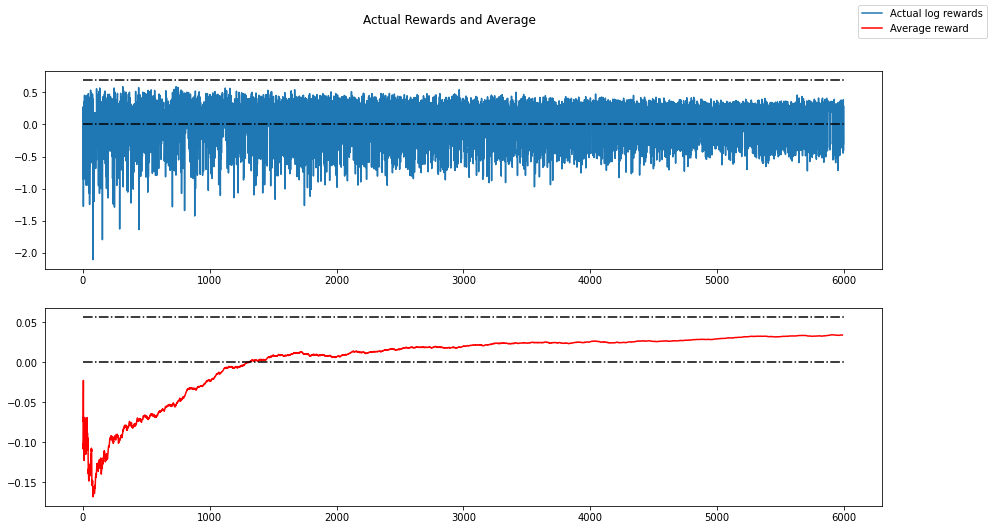

In [51]:
best = 2/3*(np.log(2/3)-np.log(1/2)) + 1/3*(np.log(1/3)-np.log(1/2))
print('Towards best ratio: ', max(reward_history[100:, 1])/ best)
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(reward_history[:, 0], label = 'Actual log rewards', zorder=-100)
axs[1].plot(reward_history[10:, 1], 'r',zorder= -99, label = 'Average reward')
axs[0].hlines(y=np.log(2), xmin=0, xmax=reward_history.shape[0], colors='black', linestyles='dashdot')
axs[0].hlines(y=0.0, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
axs[1].hlines(y=0.0, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
axs[1].hlines(y=best, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Actual Rewards and Average')

In [52]:
# fig = plt.figure(figsize=(15, 4))
# plt.plot(reward_history[:, 0], zorder = -100, label = 'Reward', alpha = 0.7)
# plt.plot(reward_history[:, 1], zorder= -99, label = 'Average reward')
# # plt.plot(agent.reward_history[1:, 2], 'r', zorder= -101, label = 'Difference' )
# plt.hlines(y=np.log(2), xmin=0, xmax=reward_history.shape[0], colors='black', linestyles='dashdot')
# plt.hlines(y=0.0, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
# plt.legend()
# plt.title('Rewards and Baseline')

Text(0.5, 1.0, 'Approximated value and Actual value')

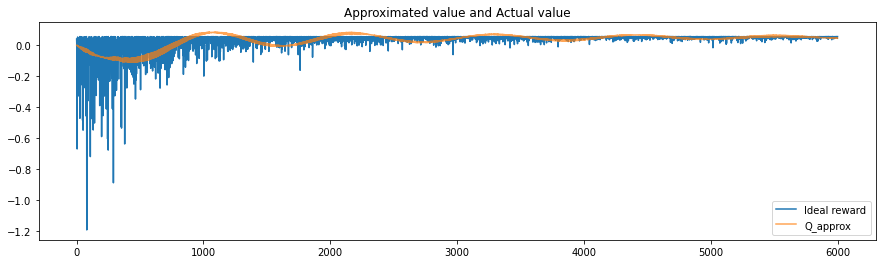

In [53]:
fig = plt.figure(figsize=(15, 4))
plt.plot(q_ideal_reward_array[:, 0], zorder = -100, label = 'Ideal reward')
plt.plot(q_ideal_reward_array[:, 1], zorder= -99, label = 'Q_approx', alpha = 0.7)
# plt.plot(agent.reward_history[1:, 2], 'r', zorder= -101, label = 'Difference' )
# plt.hlines(y=np.log(2), xmin=0, xmax=reward_history.shape[0], colors='black', linestyles='dashdot')
# plt.hlines(y=0.0, xmin=0, xmax=reward_history.shape[0] , colors='black', linestyles='dashdot')
plt.legend()
plt.title('Approximated value and Actual value')

2980


Text(0.5, 1.0, 'Report')

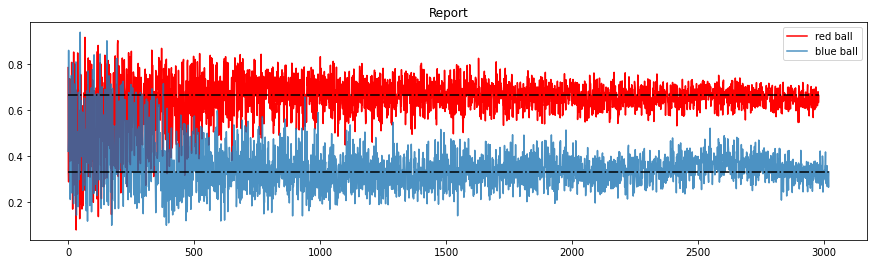

In [54]:
print(len(r_ball_pred_history_list))
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_pred_history_list, 'r',zorder=-100, label='red ball')
plt.plot(b_ball_pred_history_list, zorder=-99, label = 'blue ball', alpha=0.8)
plt.hlines(y=2/3, xmin=0, xmax=len(r_ball_pred_history_list), colors='black', linestyles='dashdot')
plt.hlines(y=1/3, xmin=0, xmax=len(b_ball_pred_history_list) , colors='black', linestyles='dashdot')
plt.legend()
plt.title('Report')

In [55]:
print(agent.report([1, 0, 0.5]))

[0.6661394570799027, 0.33386054292009726]


In [56]:
print(agent.report([0, 1, 0.5]))

[0.3990559907056381, 0.6009440092943619]


Text(0.5, 1.0, 'Mean')

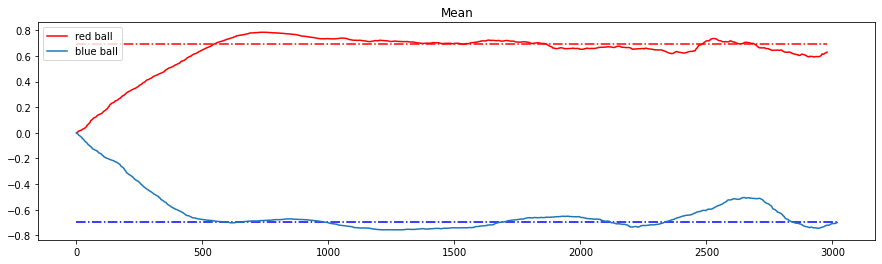

In [57]:
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_mean_history_list, 'r', label = 'red ball')
plt.plot(b_ball_mean_history_list,label = 'blue ball')
plt.hlines(y=np.log(2), xmin=0, xmax=len(r_ball_mean_history_list), colors='red', linestyles='dashdot')
plt.hlines(y=np.log(1/2), xmin=0, xmax=len(b_ball_mean_history_list) , colors='blue', linestyles='dashdot')
plt.legend()
plt.title('Mean')

Text(0.5, 1.0, 'Weights for Mean')

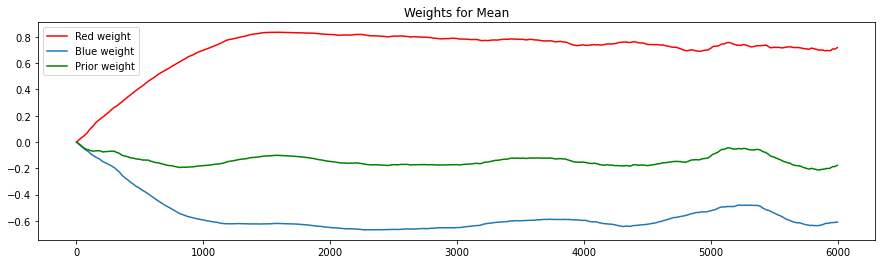

In [58]:
fig = plt.figure(figsize=(15, 4))
plt.plot(mean_weights_history[1:, 0], 'r', label='Red weight')
plt.plot(mean_weights_history[1:, 1], label='Blue weight')
plt.plot(mean_weights_history[1:, 2], 'g', label='Prior weight')
plt.legend()
plt.title('Weights for Mean')

Text(0.5, 1.0, 'Standard Diviation')

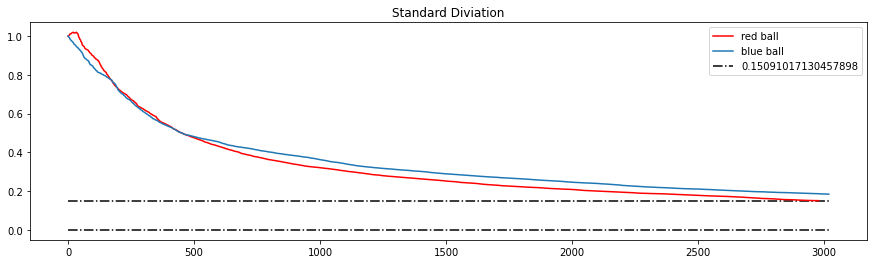

In [59]:
min_std = min(r_ball_std_history_list) if min(r_ball_std_history_list) < min(b_ball_std_history_list) else min(b_ball_std_history_list)
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_std_history_list, 'r', label = 'red ball')
plt.plot(b_ball_std_history_list,label = 'blue ball')
plt.hlines(y=0, xmin=0, xmax=len(b_ball_std_history_list) , colors='black', linestyles='dashdot')
plt.hlines(y=min_std, xmin=0, xmax=len(b_ball_std_history_list) , colors='black', linestyles='dashdot', label=str(min_std))
plt.legend()
plt.title('Standard Diviation')

Text(0.5, 1.0, 'Weights for standard diviation')

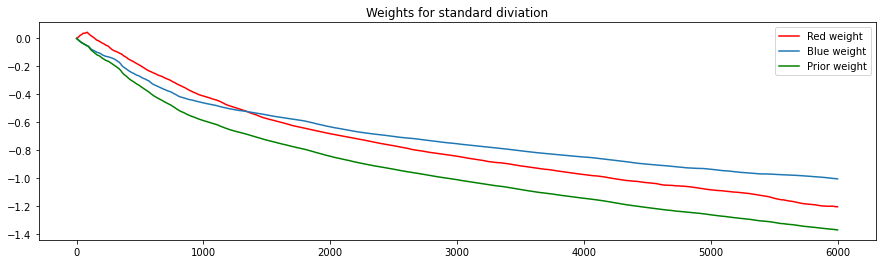

In [60]:
fig = plt.figure(figsize=(15, 4))
plt.plot(std_weights_history[:, 0], 'r', label='Red weight')
plt.plot(std_weights_history[:, 1], label='Blue weight')
plt.plot(std_weights_history[:, 2], 'g', label='Prior weight')
plt.legend()
plt.title('Weights for standard diviation')

Text(0.5, 0.98, 'Signal Mean Gradients')

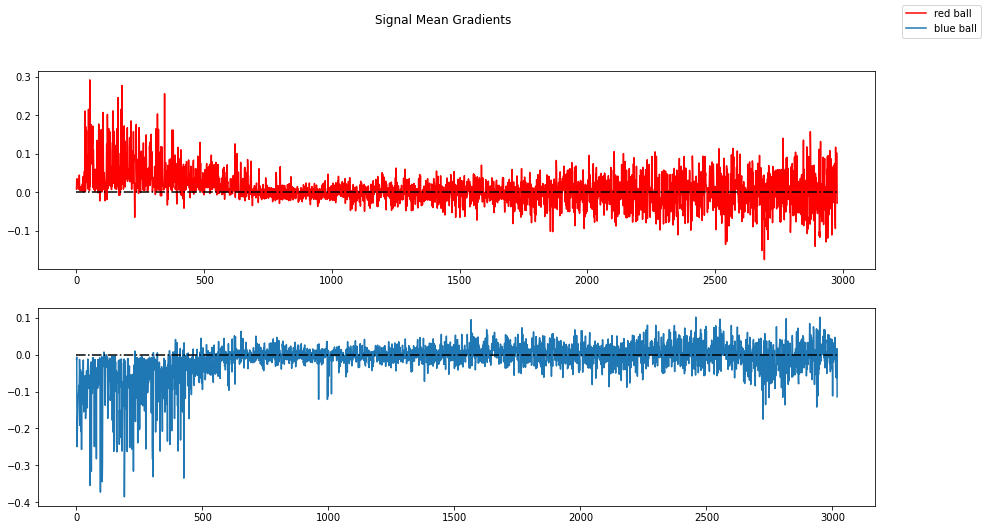

In [61]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_mean_history[:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_mean_history[:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients')

Text(0.5, 0.98, 'Signal Mean Gradients (momentum)')

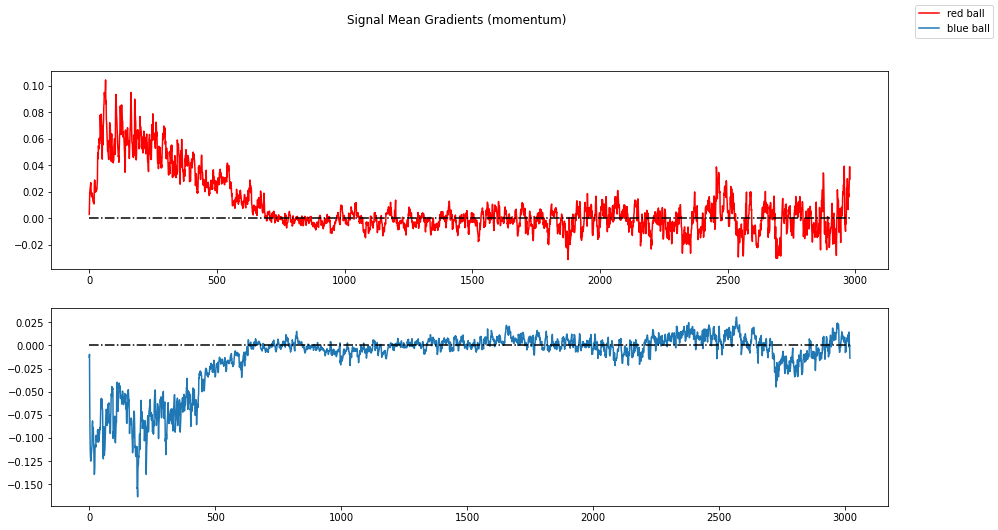

In [62]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_mean_history[:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_v_mean_history[:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (momentum)')

Text(0.5, 0.98, 'Signal Mean Gradients (Adam)')

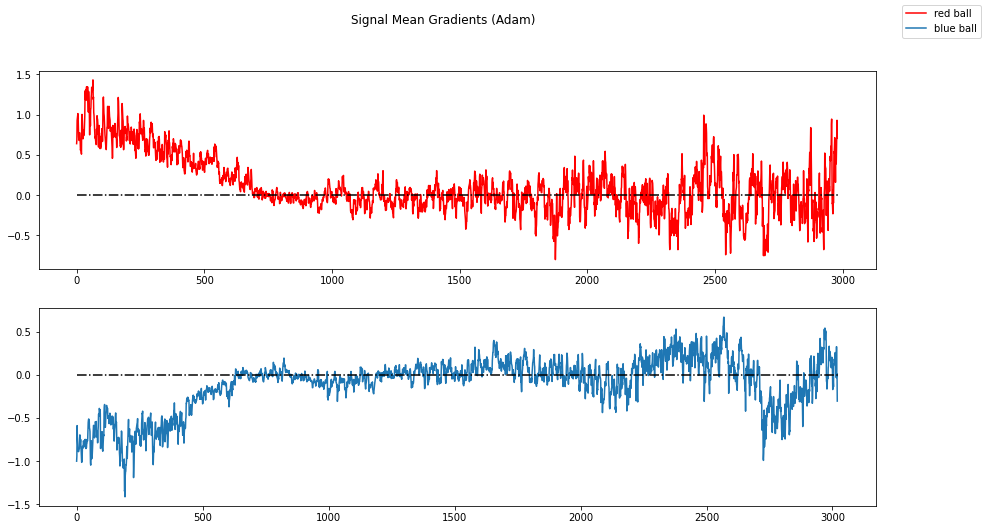

In [63]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_adam_mean_history[:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_adam_mean_history[:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients (Adam)')

Text(0.5, 0.98, 'Prior Mean Gradient')

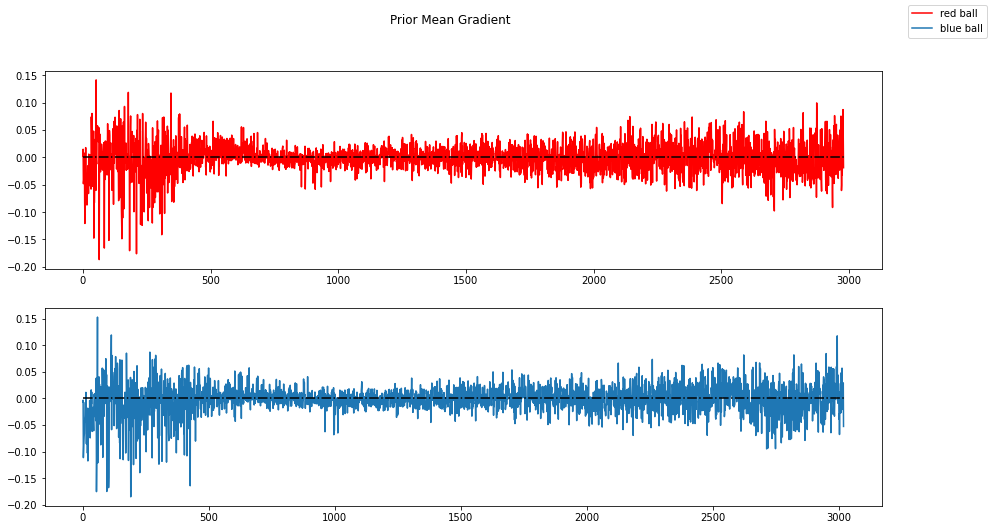

In [64]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_mean_history[:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_mean_history[:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Prior Mean Gradient')

Text(0.5, 0.98, 'Prior Mean Gradient (Momentum)')

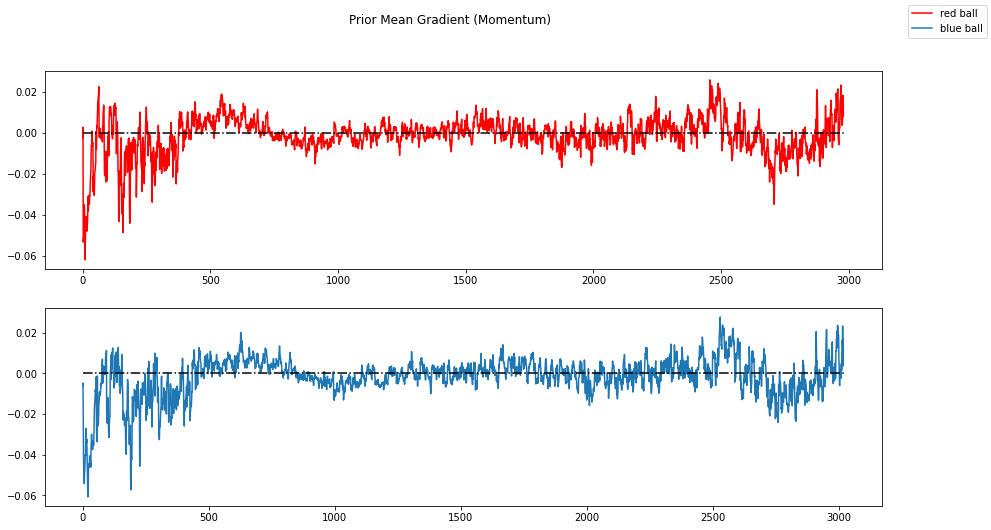

In [65]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_mean_history[:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_v_mean_history[:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Prior Mean Gradient (Momentum)')

Text(0.5, 0.98, 'Signal Standard Diviation Gradient')

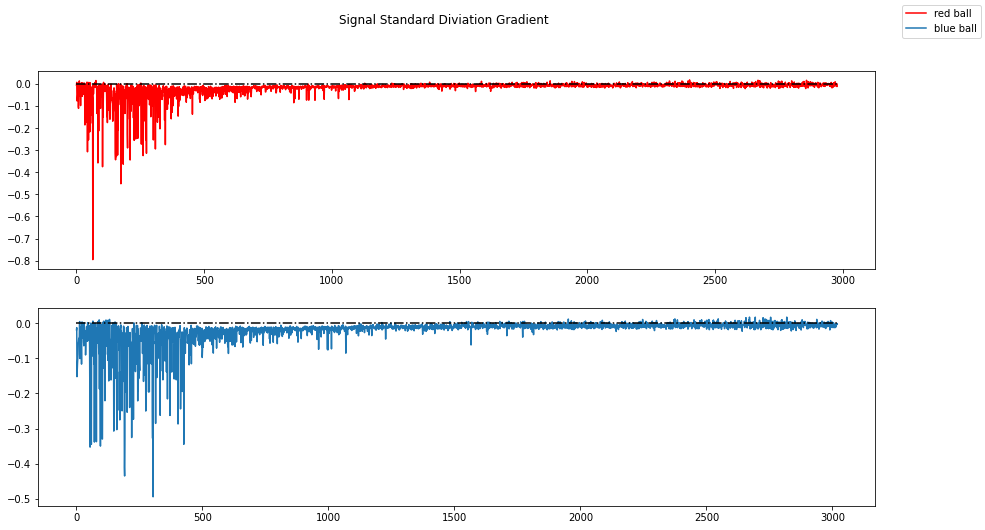

In [66]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_std_history[:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_std_history[:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_std_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_std_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Standard Diviation Gradient')

In [67]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_std_history[:, 0], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_v_std_history[:, 1],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Standard Diviation Gradient (Momentum)')

Text(0.5, 0.98, 'Signal Standard Diviation Gradient (Momentum)')

Error in callback <function flush_figures at 0x1830be820> (for post_execute):


KeyboardInterrupt: 

Text(0.5, 0.98, 'Signal Standard Diviation Gradient (Adam)')

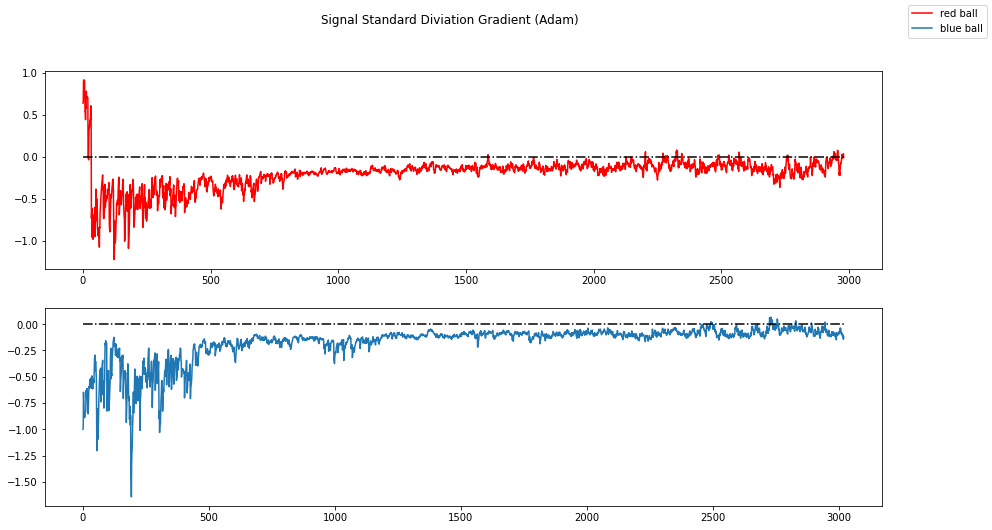

In [68]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_adam_std_history[:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_adam_std_history[:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Standard Diviation Gradient (Adam)')